# Прогнозы и предсказания

Сеть фитнес-центров "Культурист-Датасатанист" хочет подготовить план действий по удержанию своих клиетов, а для этого их нужно разбить на группы и спрогнозировать отток.

<details>
 <summary>Поля в датасете</summary>
 <li><b>gender</b> - пол</li>
 <li><b>near_location</b> - проживание или работа рядом с фитнес-центром</li>
 <li><b>partner</b> - сотрудник компании-партнёра</li>
 <li><b>promo_friends</b> - пришёл по акции "приведи друга"</li>
 <li><b>phone</b> - наличие контактного телефона</li>
 <li><b>contract_period</b> - возраст</li>
 <li><b>group_visits</b> - посещение групповых занятий</li>
 <li><b>age</b> - возраст</li>
 <li><b>avg_additional_charges_total</b> - средняя выручка от сопутствующих услуг/товаров</li>
 <li><b>month_to_end_contract</b> - число месяцев до конца абонемента</li>
 <li><b>lifetime</b> - число месяцев с первого посещения</li>
 <li><b>avg_class_frequency_total</b> - средняя частота посещений в неделю</li>
 <li><b>avg_class_frequency_current_month</b> - средняя частота посещений за предыдущий месяц</li>
 <li><b>churn</b> - факт оттока в текущем месяце</li>

## Структура проекта
1. [Начало](#inception)
1. [EDA](#eda)
1. [ML](#ml)
1. [Выводы](#conclusions)

---

## Начало
<a id='inception' name='inception'></a>
Необходимые импорты, переменные, настройки

In [1]:
!pip install seaborn --upgrade -q

In [2]:
from os import environ
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')  

In [3]:
pd.set_option(
    'display.float_format', lambda x: '%.3f' % x
)

sns.set(
    rc = {
        'figure.figsize': (17, 10),
        'figure.dpi': 80,
        'axes.grid': True,
        'axes.grid.axis': 'y',
        'axes.grid.which': 'both',
        'grid.alpha': .4,
        # 'xtick.minor.visible': True,
        },
    palette = 'colorblind',
    style = 'ticks'
)

In [4]:
def read_csv(func: 'pd.read_csv'=pd.read_csv) ->pd.DataFrame:
    """Wrapper for pd.read_csv."""
    def wrapper(*args, **kwargs: 'pd.read_csv parameters') -> pd.DataFrame:
        """
        Return a DataFrame from csv with true and ordered columns and sort by
        datetime, and display 5 randow rows and df.info().
        """
        df = func(*args, **kwargs)
        

        if kwargs.get('names', None) is None:
            df.columns = [
                re.sub('([a-z])([A-Z]+)', r'\1_\2', col).strip().lower().replace(' ', '_') 
                for col 
                in df.columns
                ]

        parse_dates = kwargs.get('parse_dates', None)
        if parse_dates is not None and df.select_dtypes('datetime').isnull:
            df.iloc[:, parse_dates[0]] = pd.to_datetime(df.iloc[:, parse_dates[0]], unit='s')

        if not df.select_dtypes('datetime').isnull:
            date_column = df.select_dtypes('datetime').columns[0]
            df = df.sort_values(date_column).reset_index(drop=True)

        columns_indeces = kwargs.get(
            'usecols', 
            np.arange(df.shape[1])
        )
        df = df.iloc[:, columns_indeces]
        
        display(
            df.sample(5, random_state=42).sort_index()
        )
        print('---------------------------------')
        display(df.describe())
        print('---------------------------------')
        df.info(memory_usage='deep')

        return df
    return wrapper

true_read_csv = read_csv()

In [5]:
try:
    PATH = environ['GYM_CHURN']
except KeyError:
    PATH = '/datasets/gym_churn.csv'

df = true_read_csv(
    filepath_or_buffer = PATH, 
)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
527,1,1,0,0,1,1,1,25,41.608,1.000,1,2.893,2.814,0
555,1,1,0,0,1,6,1,37,205.632,5.000,2,1.401,1.615,0
2989,1,1,0,0,0,1,0,30,275.272,1.000,4,1.654,1.738,0
3491,0,0,0,0,1,6,0,27,137.371,6.000,24,0.919,1.093,0
3925,1,0,0,0,1,1,0,31,9.594,1.000,14,2.132,2.147,0


---------------------------------


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000
mean,0.510,0.845,0.487,0.308,0.903,4.681,0.412,29.184,146.944,4.323,3.725,1.879,1.767,0.265
std,0.500,0.362,0.500,0.462,0.295,4.550,0.492,3.258,96.356,4.191,3.749,0.972,1.053,0.442
min,0.000,0.000,0.000,0.000,0.000,1.000,0.000,18.000,0.148,1.000,0.000,0.000,0.000,0.000
25%,0.000,1.000,0.000,0.000,1.000,1.000,0.000,27.000,68.869,1.000,1.000,1.181,0.963,0.000
50%,1.000,1.000,0.000,0.000,1.000,1.000,0.000,29.000,136.220,1.000,3.000,1.833,1.720,0.000
75%,1.000,1.000,1.000,1.000,1.000,6.000,1.000,31.000,210.950,6.000,5.000,2.536,2.510,1.000
max,1.000,1.000,1.000,1.000,1.000,12.000,1.000,41.000,552.591,12.000,31.000,6.024,6.147,1.000


---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [6]:
cols = df.select_dtypes('int').columns
df[cols] = df[cols].astype('uint8')

In [7]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null uint8
near_location                        4000 non-null uint8
partner                              4000 non-null uint8
promo_friends                        4000 non-null uint8
phone                                4000 non-null uint8
contract_period                      4000 non-null uint8
group_visits                         4000 non-null uint8
age                                  4000 non-null uint8
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null uint8
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null uint8
dtypes: float64(4), uint8(10)
memory usage: 164.2 KB


Пропусков нет, типы данных нормальные.
<br>
Перейдём к предобработке.

---

## EDA
<a name='eda' id='eda'></a>
Посмотрим, на что можно посмотреть

Средний клиент сети:
- находится близко к фитнес-центру (85%)
- пришёл сам (70%)
- указал номер телефона
- имеет абонемент на 4.6 месяца
- иногда ходит на групповые занятия (40%)
- 29 лет
- приносит 146 у.е. с доп.услуг
- ходит на занятия пару раз в неделю
<br>
Стандартное отклонение в основном меньше единицы (не удивительно, так как большинство признаков бинарные), очень большой разброс по доп.услугам

Посмотрим грубые дубликаты:

In [8]:
df.duplicated().sum()

0

Их нет.
<br>
Посмотрим на различия между теми, кто ушёл, и теми, кто остался:

In [9]:
df.groupby('churn').mean().T

churn,0,1
gender,0.510,0.511
near_location,0.873,0.768
partner,0.534,0.355
promo_friends,0.354,0.184
phone,0.904,0.903
contract_period,5.747,1.729
group_visits,0.464,0.269
age,29.977,26.990
avg_additional_charges_total,158.446,115.083
month_to_end_contract,5.283,1.663


Среди оставшихся почти на 20% больше тех, кто работает в компании-партнёре, а так же больше чем на 10% тех, кто пришёл по акции "приведи друга" и тех, кто работает или живёт рядом с фитнес-центром. 
<br>
Средний срок абонемента у оставшихся больше в 3 раза, а так же они чуть старше.
<br>
Также чаще уходят те, у кого абонемент ближе к концу, а их <i>lifetime</i> равен одному месяцу. Так же они в среднем ходят на занятия меньше, чем те, кто не оттёк.

Посмотрим на распределения этих признаков:

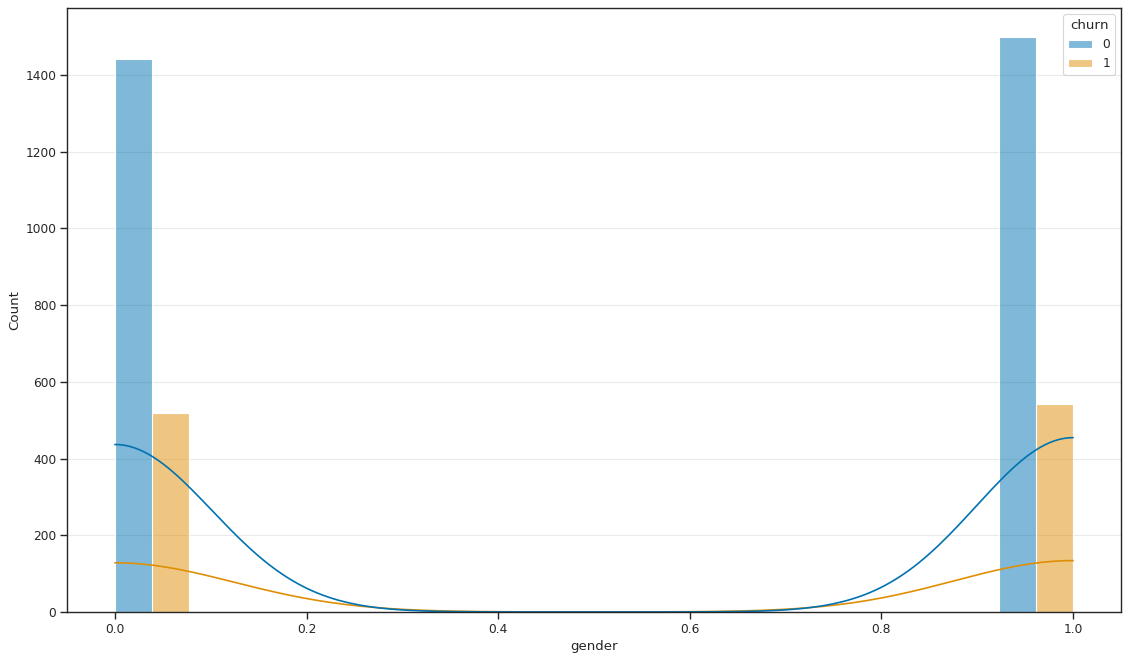

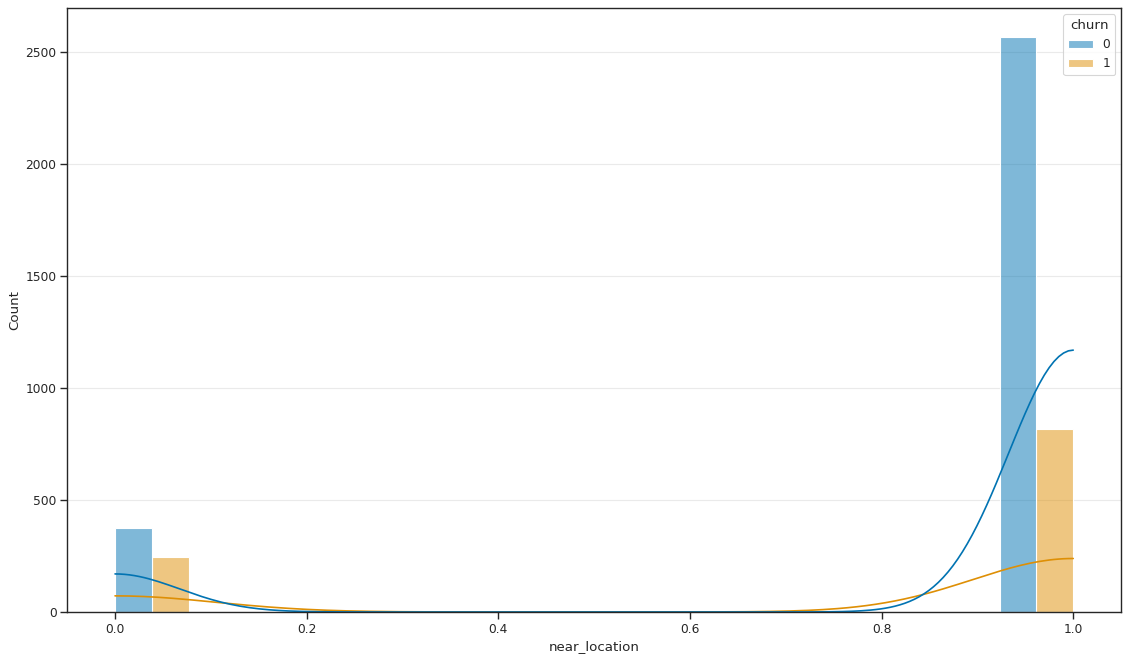

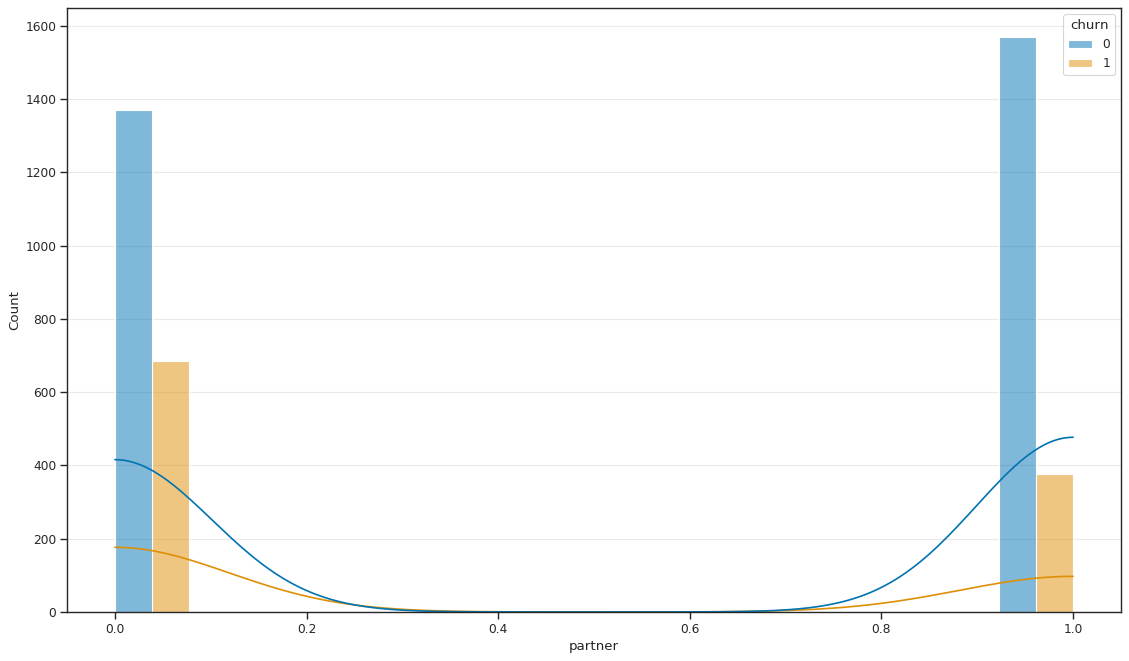

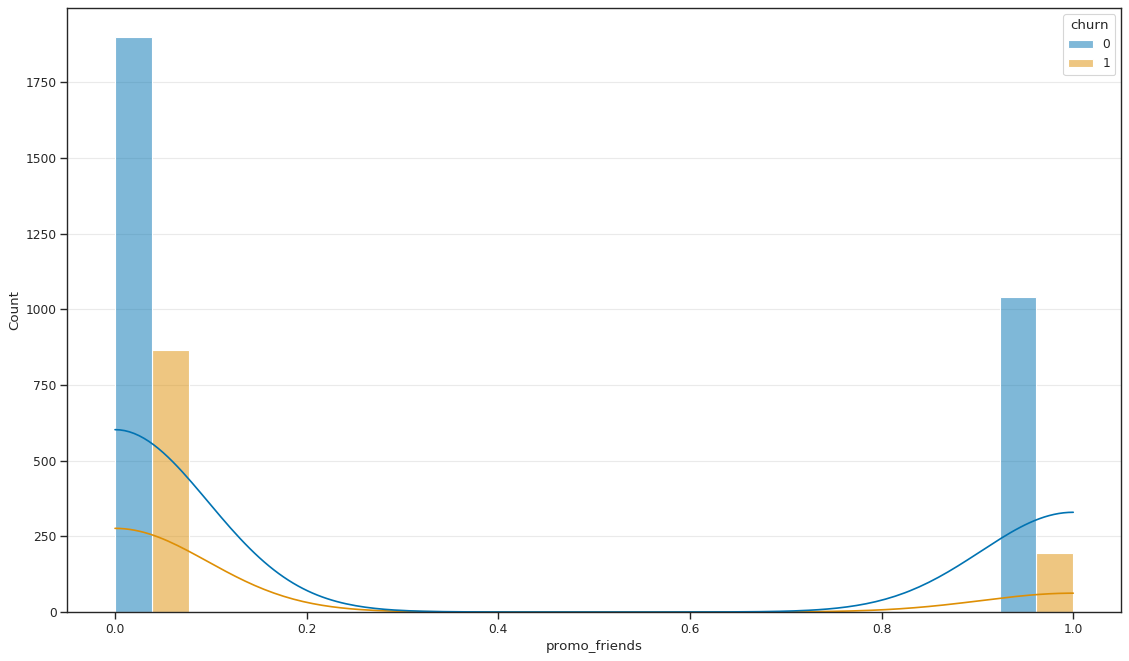

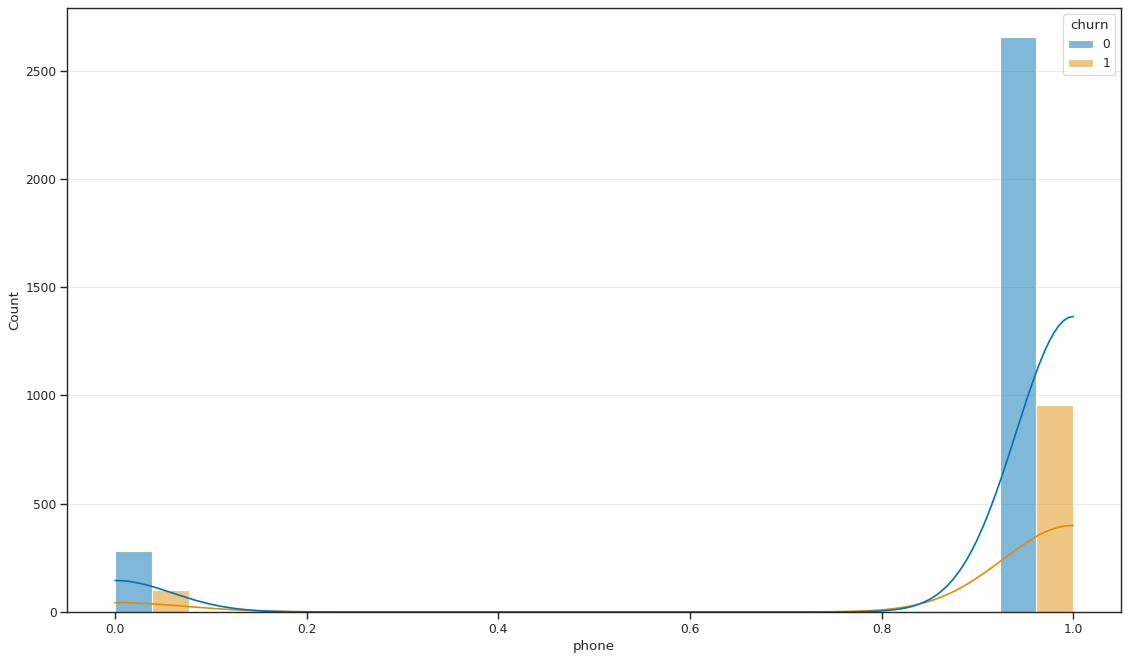

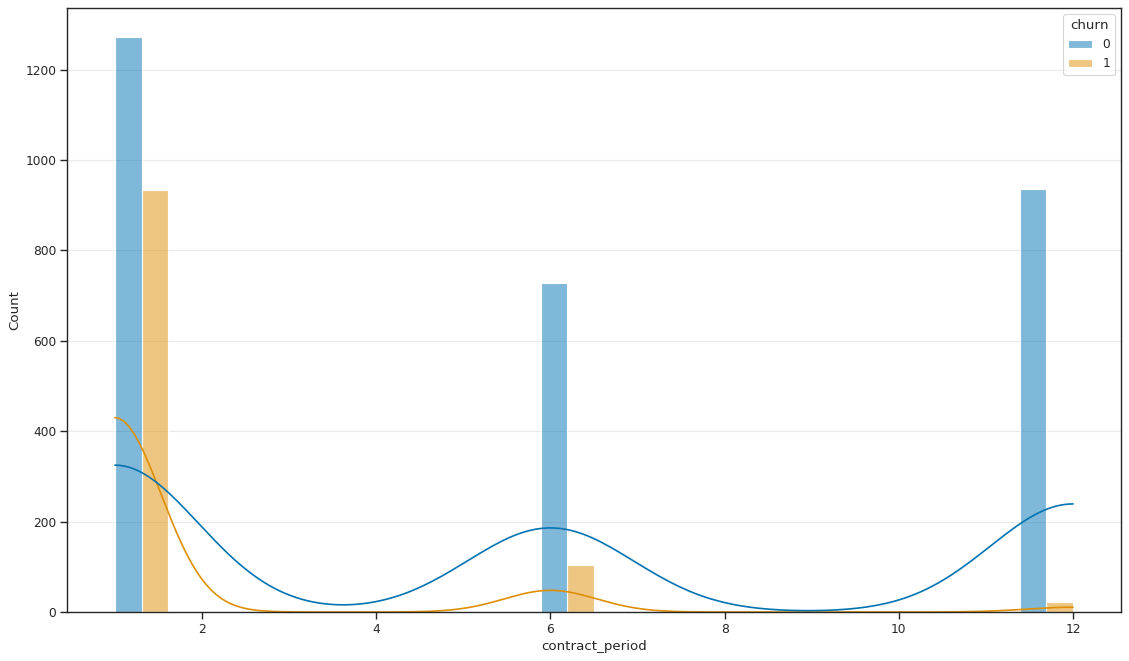

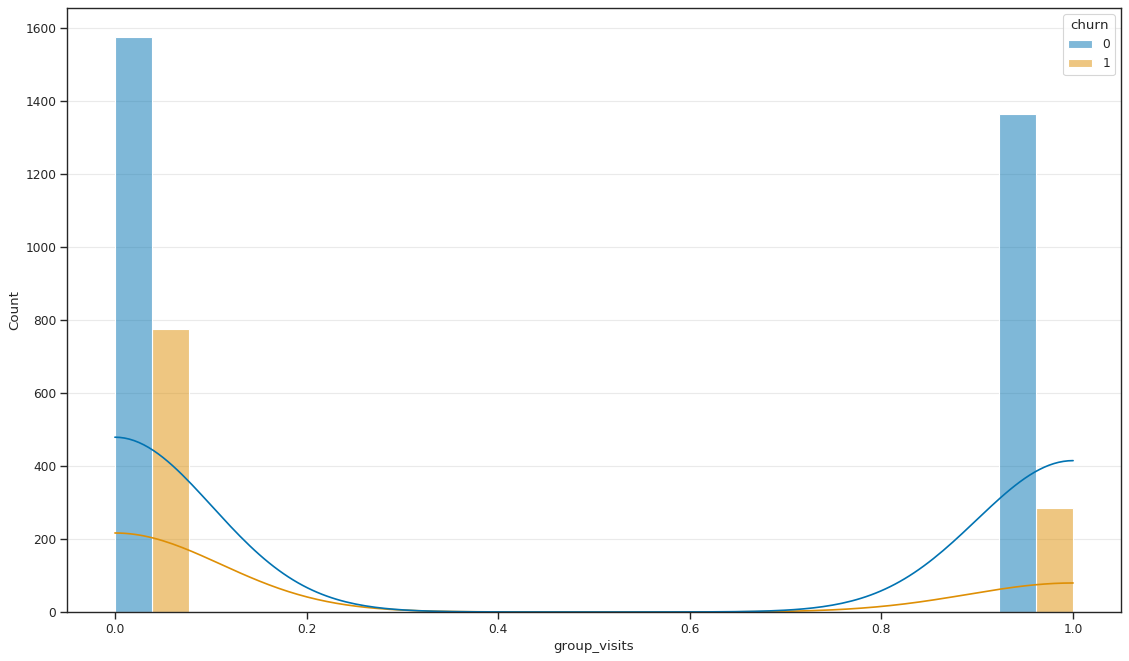

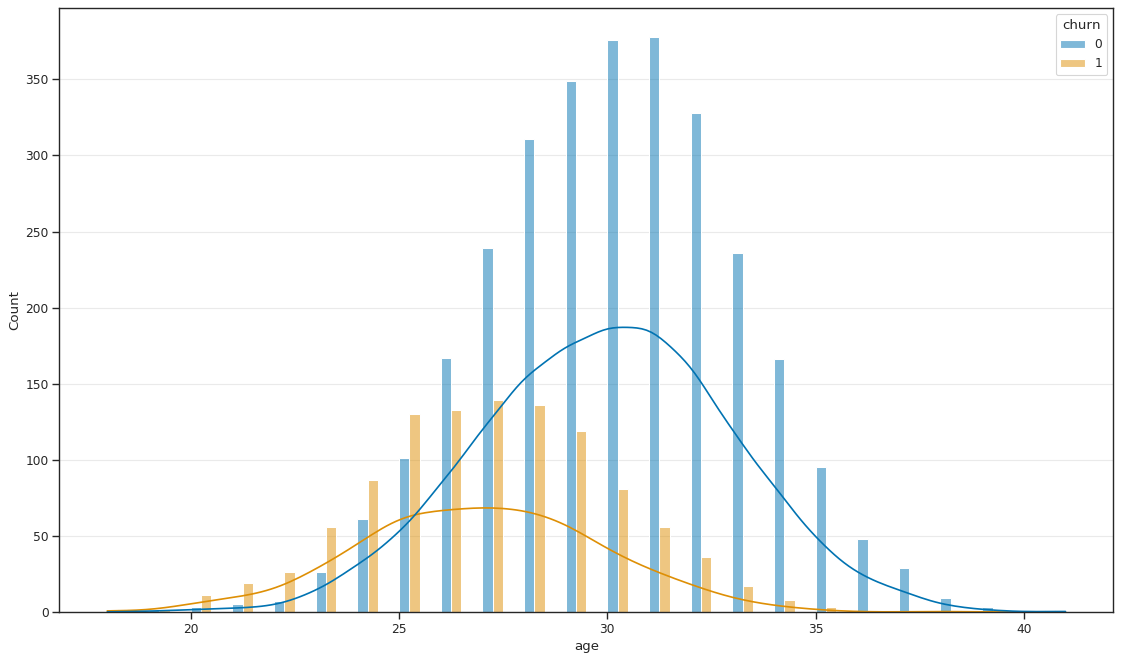

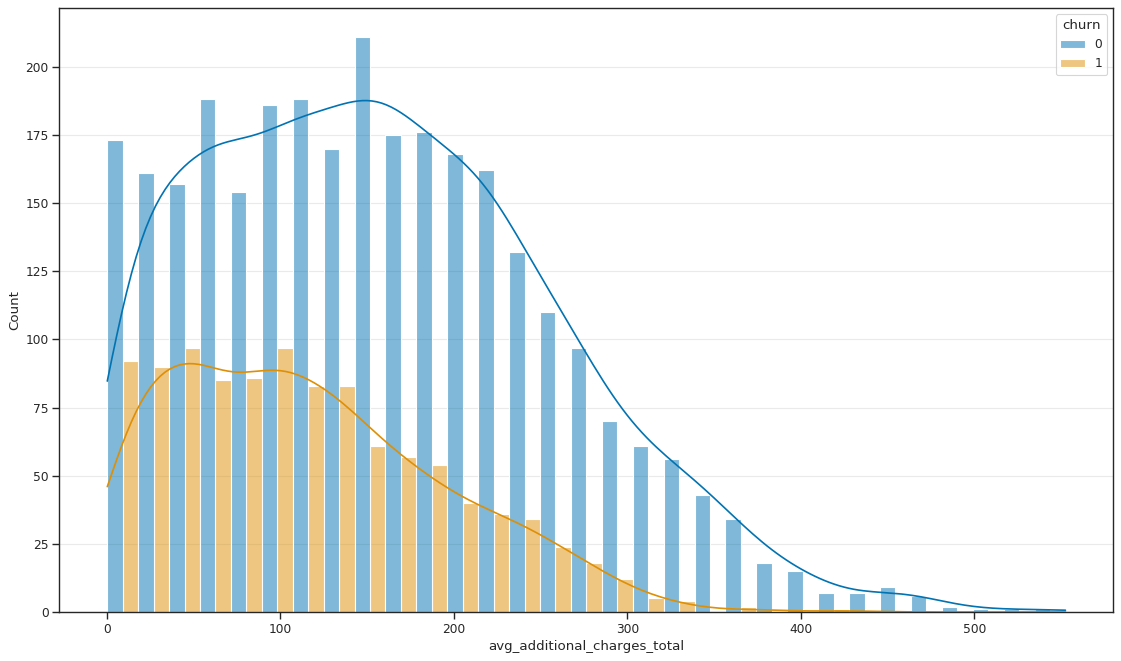

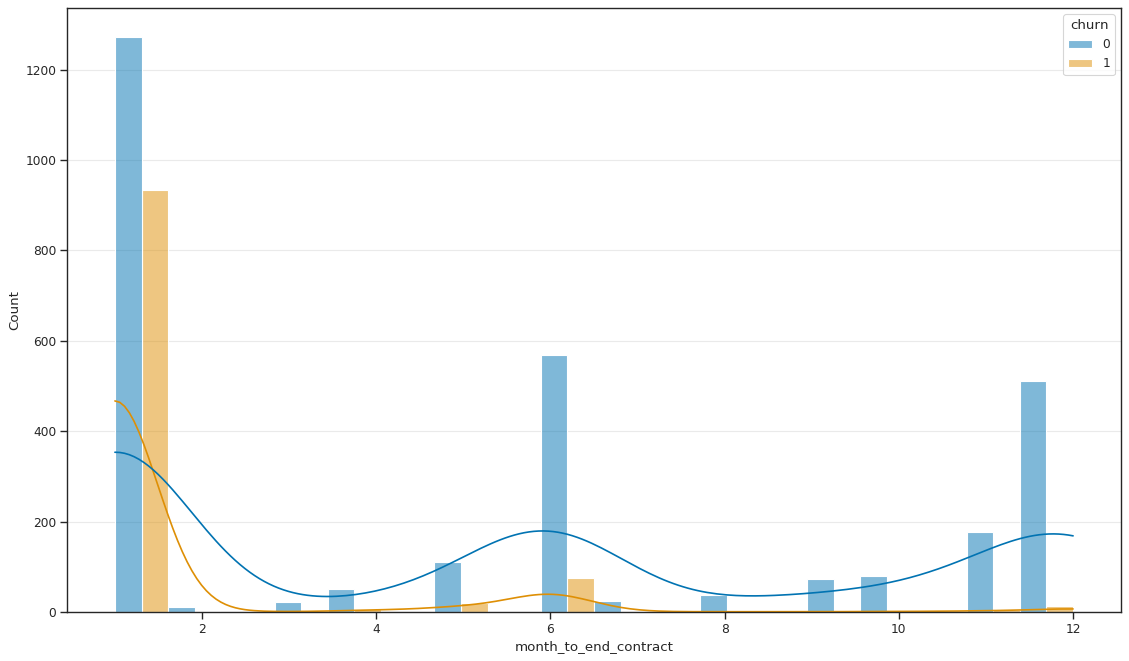

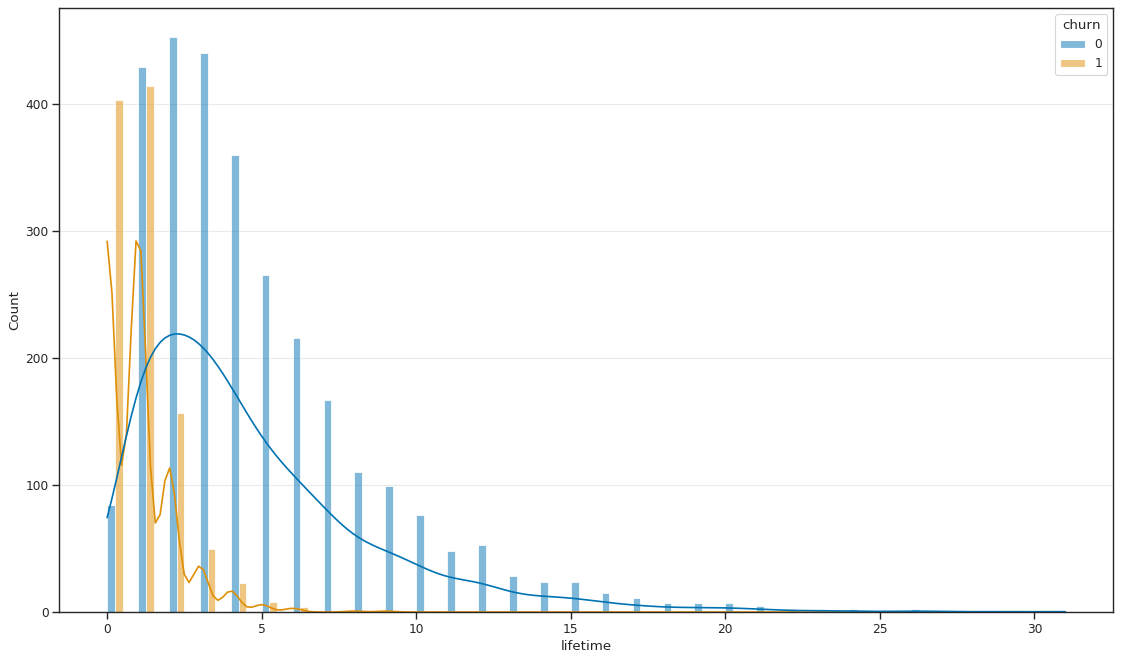

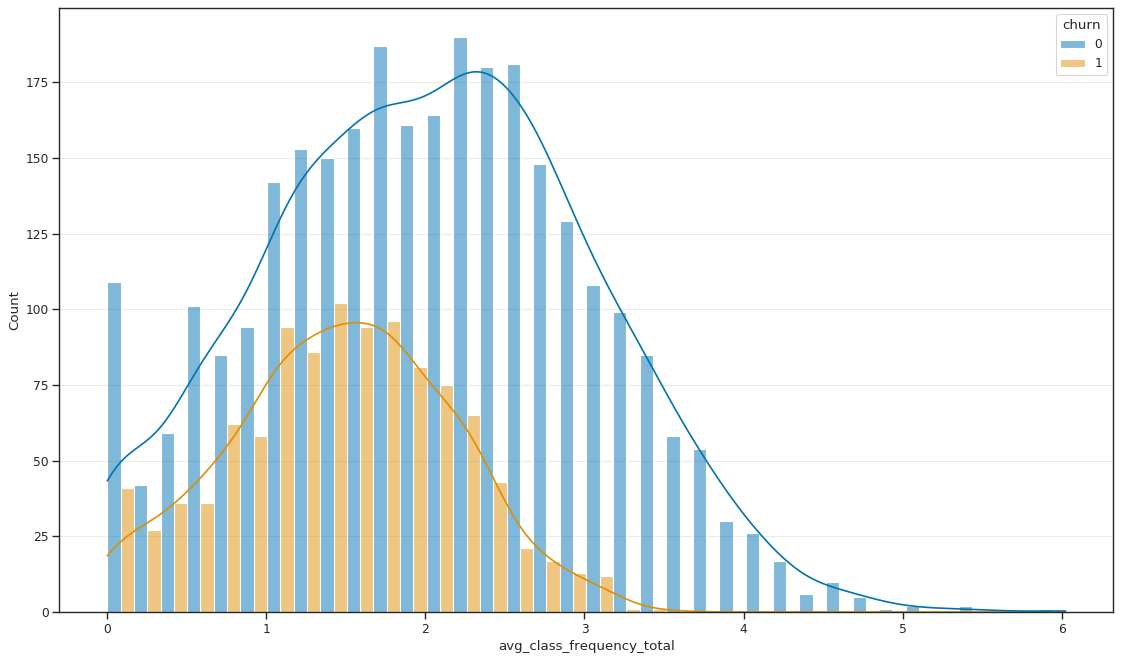

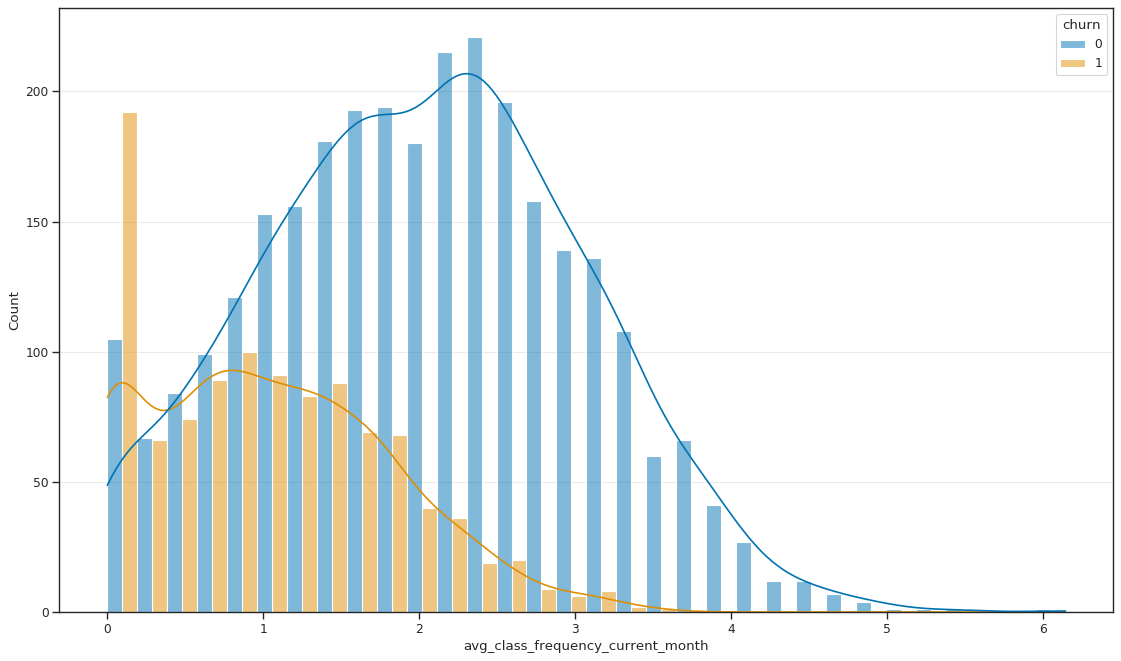

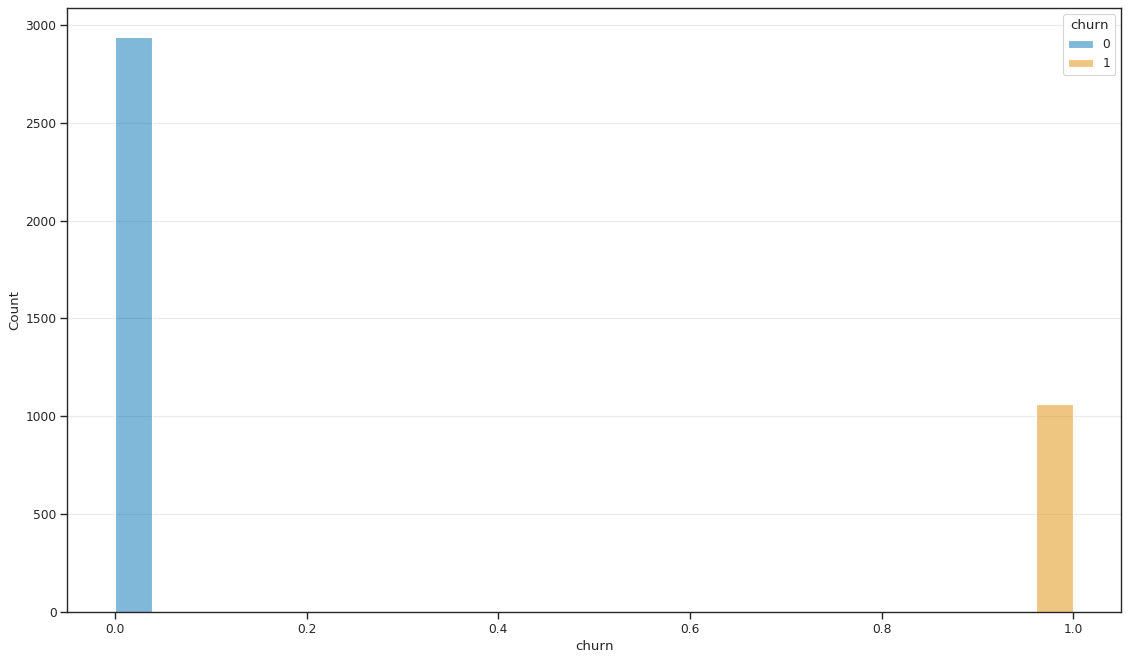

In [10]:
for col in df:
    sns.histplot(
        data = df,
        x = col,
        hue = 'churn',
        kde = True,
        multiple = 'dodge',
    )
    plt.show()

Взглянем также на матрицу корреляций:

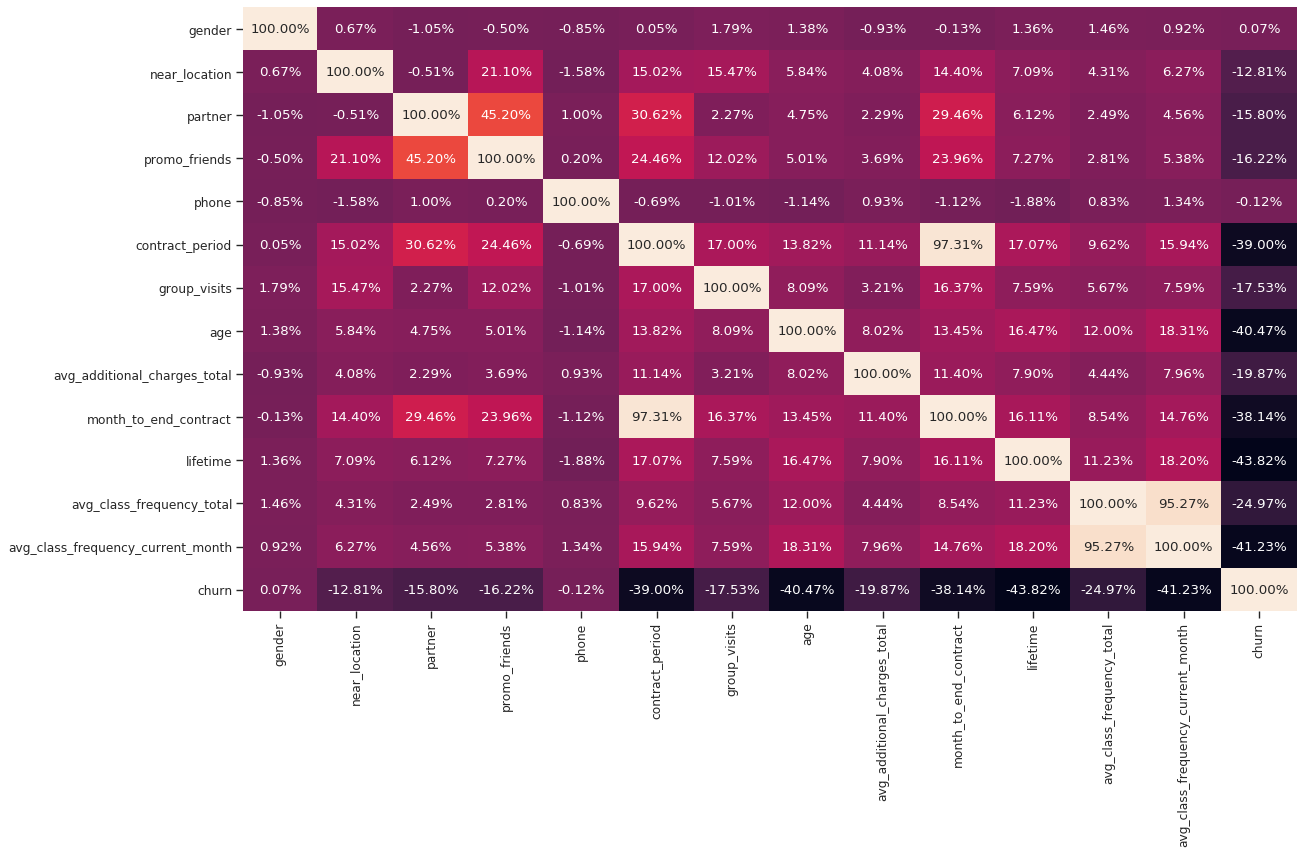

In [11]:
sns.heatmap(
    data = df.corr(),
    annot = True,
    fmt = '.2%',
    cbar = None
)
plt.show()

Видно, что у нас есть две пары коррелирующих признаков - *contract_period - month_to_end_contract* и *avg_class_frequency_total - avg_class_frequency_current_month*.
<br>
Нужно будет исключить по одному из этих признаков.
<br>
Разделим модель на обучающую и валидационную выборки (временных рядов нет, поэтому разделим рандомно):

In [12]:
y = df['churn']
X = df.drop(columns=['churn', 'month_to_end_contract', 'avg_class_frequency_current_month'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

Сразу стандартизируем данные:

In [13]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

---

## ML
<a id='ml' name='ml'></a>
Обучим пару моделек

Начнём с прогнозирования оттока, обучим алгоритмы логистической регрессии и случайный лес:

In [14]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_pred = lr_model.predict(X_test_st)
lr_prob = lr_model.predict_proba(X_test_st)[:,1]

rf_model = RandomForestClassifier(n_estimators=500, random_state=0)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:,1]

Взглянем на метрики:

In [15]:
print('Метрики логистической регрессии:')
print('accuracy_score: {}\nprecision_score: {}\nrecall_score:{}'.format(
    accuracy_score(y_test, lr_pred),
    precision_score(y_test, lr_pred),
    recall_score(y_test, lr_pred)
))
print() 

print('Метрики случайного леса:')
print('accuracy_score: {}\nprecision_score: {}\nrecall_score:{}'.format(
    accuracy_score(y_test, rf_pred),
    precision_score(y_test, rf_pred),
    recall_score(y_test, rf_pred)
))
print() 

Метрики логистической регрессии:
accuracy_score: 0.9075
precision_score: 0.8254716981132075
recall_score:0.8254716981132075

Метрики случайного леса:
accuracy_score: 0.9
precision_score: 0.83
recall_score:0.7830188679245284



И на важность признаков для логистической регрессии:

In [16]:
features = pd.DataFrame(lr_model.coef_.T, X.columns).reset_index()
features.columns = ['feature', 'coef']
features['coef'] = features['coef'].apply(lambda x: abs(x))
features = features.sort_values(by='coef', ascending=False)
features

,feature,coef
9,lifetime,3.525
5,contract_period,1.339
7,age,1.136
10,avg_class_frequency_total,0.688
8,avg_additional_charges_total,0.540
6,group_visits,0.354
3,promo_friends,0.161
4,phone,0.109
1,near_location,0.073
2,partner,0.043


На основе полученных метрик модель логистической регрессии оказалась слегка точнее, чем случайный лес (по всем метрикам), и самыми важными признаками для неё оказались *lifetime, contract_period, age*. К тому же, регрессия намного проще и по ресурсам, и по принципу работы.

Теперь проведём кластеризацию.
<br>
Для этого сперва построим дендрограмму и посмотрим, какое количество кластеров будет оптимально (чтобы долго не ждать, возьмём 30% данных)

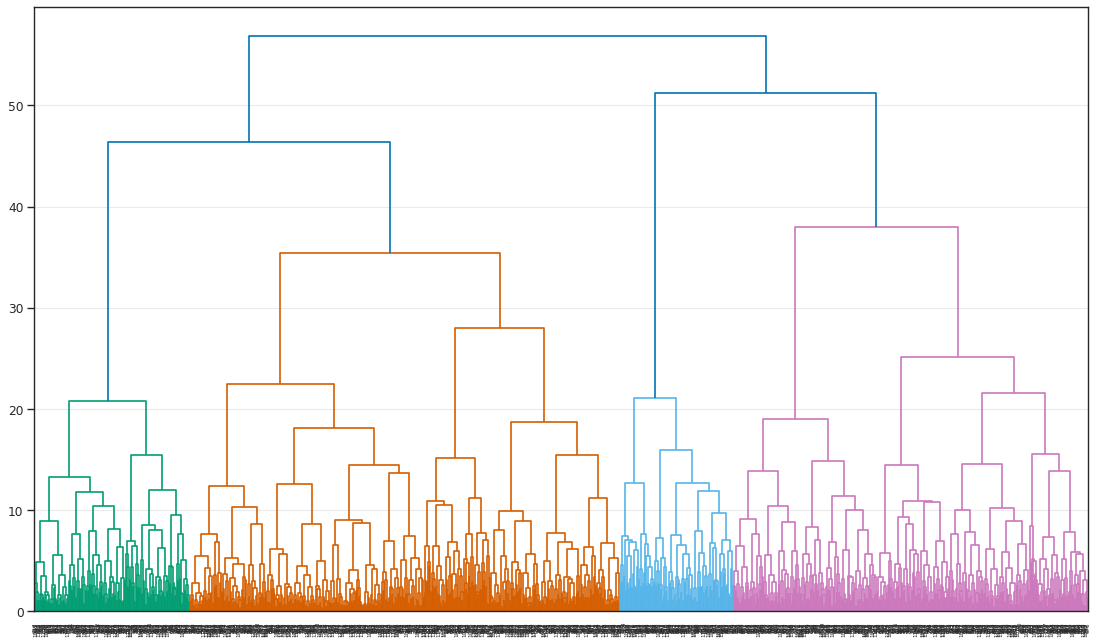

In [17]:
X = df.drop(columns=['churn'])
scaler = StandardScaler()
scaler.fit(X)
X_dendr = scaler.transform(X.sample(frac=.3, random_state=0))
linked = linkage(X_dendr, method='ward')
plt.figure()
dendrogram(linked, orientation='top')
plt.show()

Машина считает, что оптимальное количество кластеров - 4, но мы воспользуемся количеством из условий проекта:

In [18]:
X_st = scaler.transform(X)
km = KMeans(n_clusters=5, random_state=0)
df['cluster'] = km.fit_predict(X_st)

In [19]:
df.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.502,0.522,0.495,0.486,0.560
near_location,0.959,0.862,0.000,1.000,0.976
partner,0.783,0.470,0.463,0.350,0.356
promo_friends,0.575,0.306,0.079,0.240,0.229
phone,1.000,0.000,1.000,1.000,0.999
contract_period,10.884,4.787,2.352,1.948,2.665
group_visits,0.543,0.426,0.216,0.342,0.473
age,29.980,29.301,28.477,28.168,30.128
avg_additional_charges_total,160.707,143.958,135.458,131.622,161.724
month_to_end_contract,9.951,4.475,2.198,1.857,2.455


Взглянем сразу на распределения:

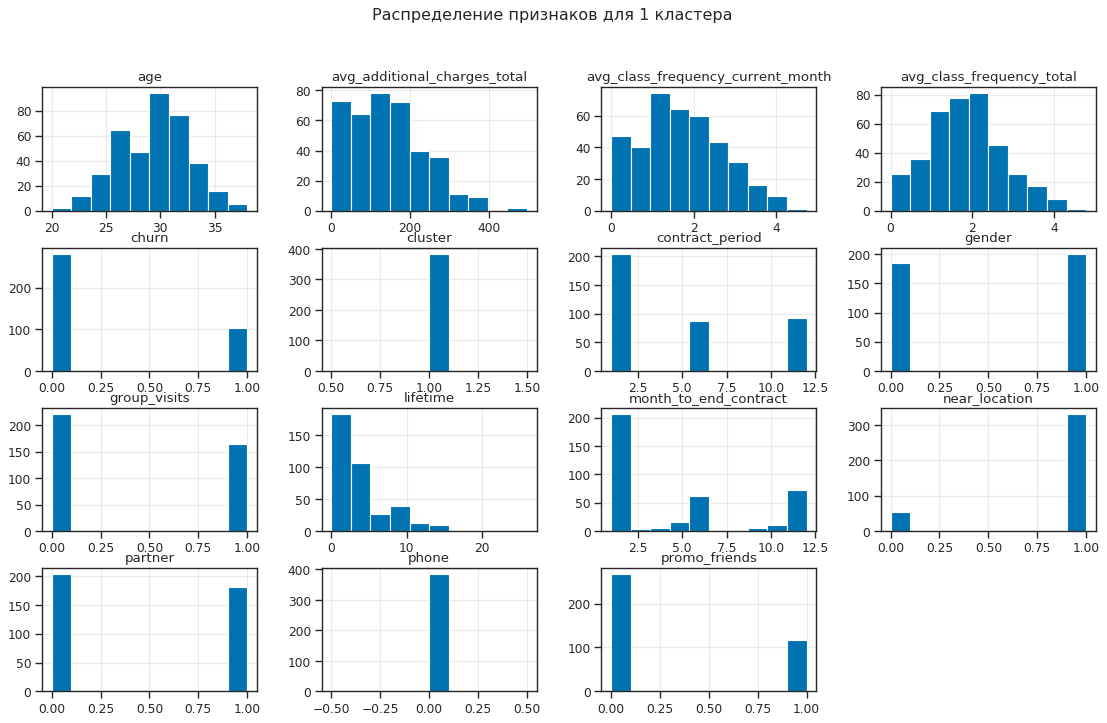

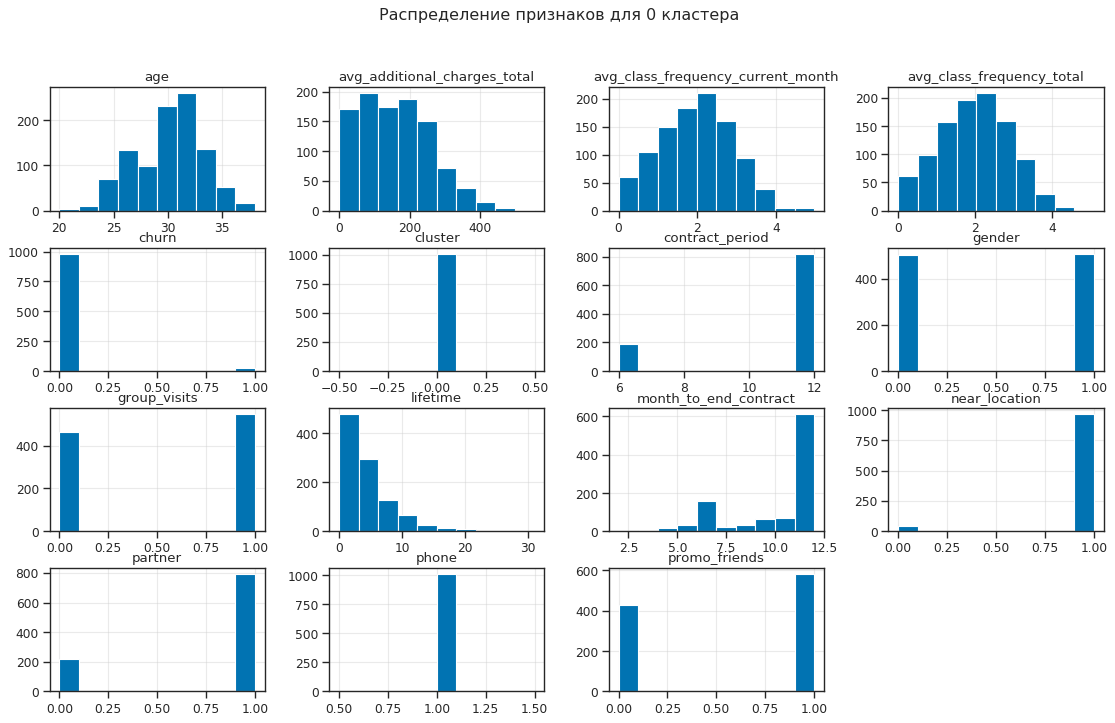

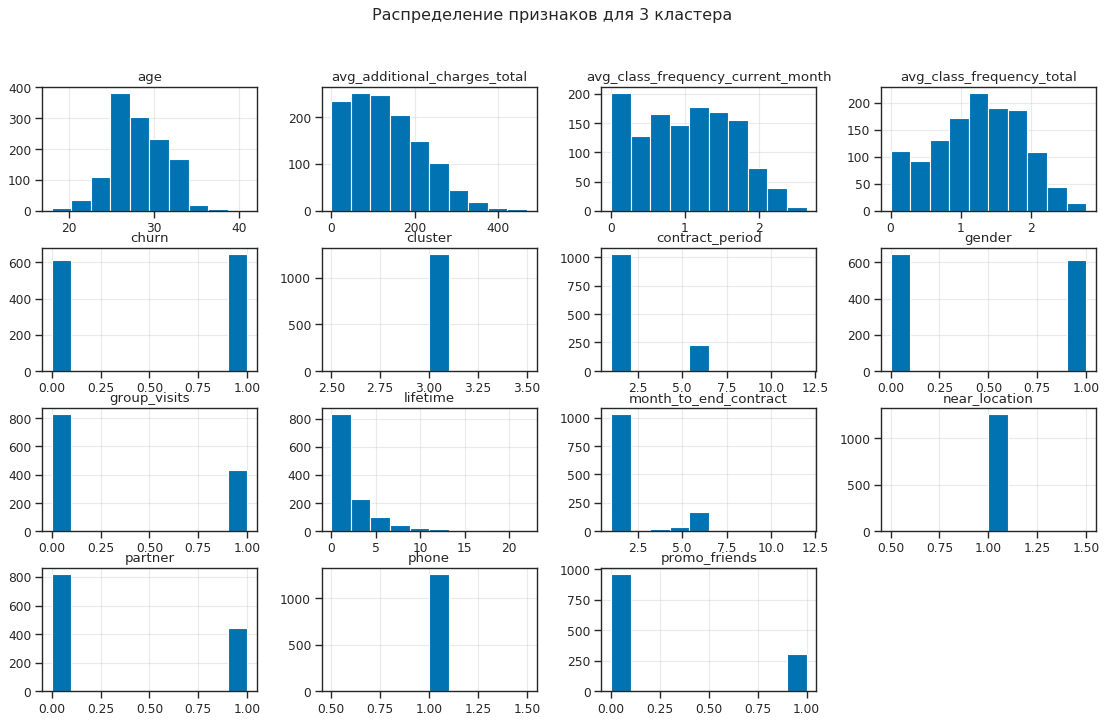

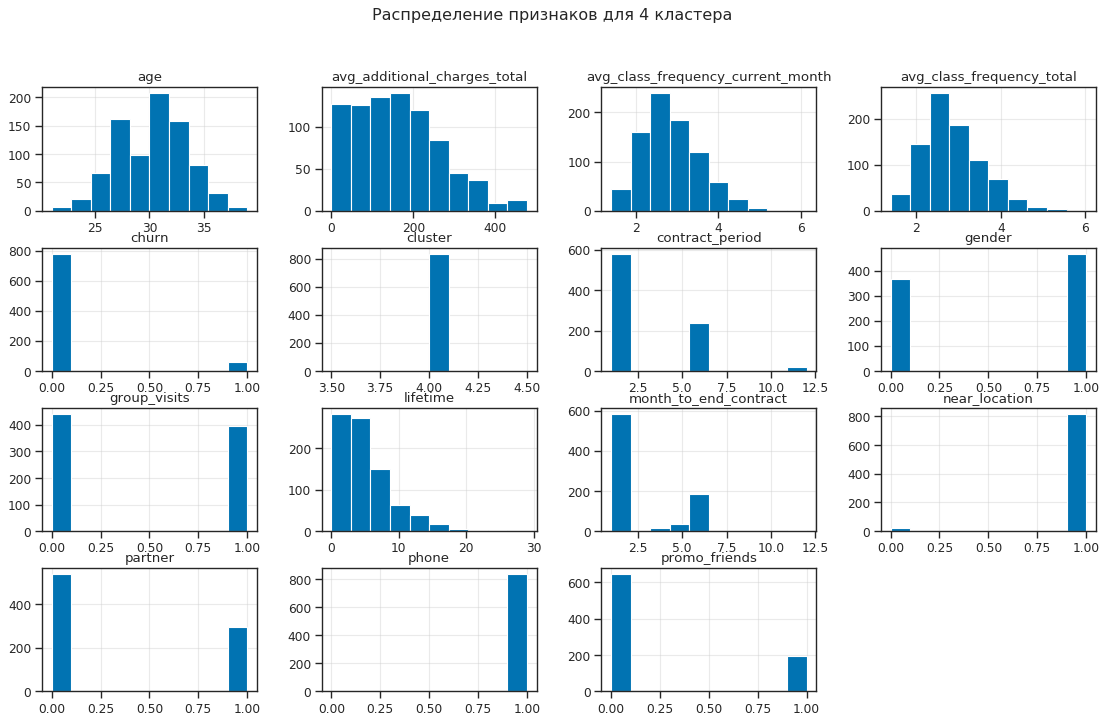

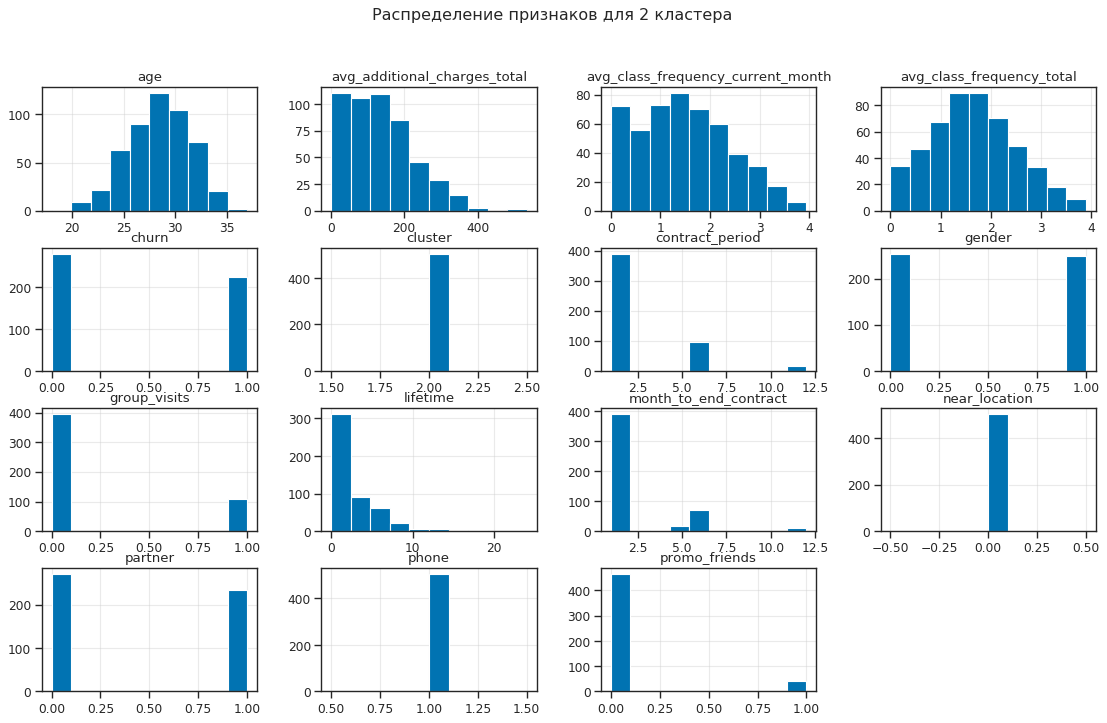

In [20]:
for cluster in df['cluster'].unique():
    df.query("cluster == @cluster").hist()
    plt.suptitle(f'Распределение признаков для {cluster} кластера')
    plt.show()

Имеем такие кластеры:
- **0** - самый долгий срок абонемента (11 месяцев), отток 3%
- **1** - обычные люди без номеров телефона, отток 27%
- **2** - живут далеко от фитнес-центров, отток 44%
- **3** - живут рядом с финтес-центром, отток 51%
- **4** - похожи на первых, но покупают абонемент на меньший срок, отток 7%

- 0 - живут или работают в основном рядом, корпоративный клиент, пришёл с другом, самые долгие абонементы, чаще других ходят на групповые занятия, стабильно ходят почти 2 раза в неделю
- 1 - не указывают телефон, приносят чуть меньше денег за доп.услуги, абонемент в 2 раза меньше, ходят чуть меньше
- 2 - живут или работают далеко, пришли сами, все указали номер телефона, ещё в 2 раза меньше абонементы, редко ходят на групповые занятия
- 3 - живут или работают рядом, у всех есть телефоны, самый короткий абонемент, самые молодые, тратят меньше всех денег, реже всех ходят
- 4 - самые старые, больше всех тратят денег, чаще всех ходят (почти 3 раза в неделю), живут или работают рядом, короткий абонемент

---

## Выводы
<a id='conclusions' name='conclusions'></a>
Подведём итоги

Проанализировав датасет и кластеры клиентов, можно сделать следующие выводы:
- люди, которые пришли по акции *приведи друга* реже оттекают
- люди, которые ходят на групповые занятия реже оттекают
- реже оттекают те, кто живёт или работает рядом
- у людей в оттоке среднее количество посещений за всё время меньше
- у клиентов в оттоке количество посещений в предыдущий месяц в два раза меньше

Исходя из этих выводов, можно **предложить**:
- стимулировать клиентов приводить своих друзей
- привлекать тех, кто живёт или работает рядом
- расширять корпоративные программы
- стимулировать посещение групповых занятий

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=73c6fdc9-2380-4d92-b495-95da9dd36eb1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>